# TCS Rio 125 internship

## Automate extraction of handwritten text from an image

### Name of the student :	Amritha R J
### Internship project title :	Automate extraction of handwritten text from an image
### Name of the company :	TCS iON
### Name of the industry mentor :	Debashis Roy
### Name of the institute :	ICTAK

In [ ]:
# Importing necessary libraries

import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

In [2]:
# Path to the folder containing images
image_folder = r'C:\Users\AMRITHA R J\Downloads\words'

# Path to the annotation file
annotation_file = r'C:\Users\AMRITHA R J\Downloads\words - Copy.txt'

In [3]:
# Reading the annotation file
with open(annotation_file) as f:
    content_lines = f.readlines()

lines = [line.strip() for line in content_lines]

In [4]:
first_line = lines[0]
print(first_line)

a01-000u-00-00 ok 154 408 768 27 51 AT A


In [5]:
max_label_length = 0
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# Encoding words to digits

def encode_text_to_labels(text):
    digit_list = []
    for index, char in enumerate(text):
        digit_list.append(char_list.index(char))
    return digit_list

In [6]:
# Creating images and labels list

images = []
labels = []

# Defining total RECORDS_COUNT

RECORDS_COUNT = 25000

In [7]:
# Creating lists to store and organize data for training and validation 

train_images = []
train_labels = []
train_input_lengths = []
train_label_lengths = []
train_original_texts = []

valid_images = []
valid_labels = []
valid_input_lengths = []
valid_label_lengths = []
valid_original_texts = []

inputs_lengths = []
labels_lengths = []

In [8]:
# User defined function for calculating aspect ratio, converting image to shape (32, 128, 1) and normalization

def process_image(image):

    width, height = image.shape
    
    # Calculate aspect ratio
    new_width = 32
    new_height = int(height * (new_width / width))
    image = cv2.resize(image, (new_height, new_width))
    width, height = image.shape
    
    image = image.astype('float32')
    
    # Resize image to shape (32, 128, 1)
    if width < 32:
        add_zeros = np.full((32 - width, height), 255)
        image = np.concatenate((image, add_zeros))
        width, height = image.shape
    
    if height < 128:
        add_zeros = np.full((width, 128 - height), 255)
        image = np.concatenate((image, add_zeros), axis=1)
        width, height = image.shape
        
    if height > 128 or width > 32:
        new_dim = (128, 32)
        image = cv2.resize(image, new_dim)
    
    image = cv2.subtract(255, image)
    
    image = np.expand_dims(image, axis=2)
    
    # Normalization 
    image = image / 255
    
    return image


In [9]:
# Processing images and labels

for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = r'C:\Users\AMRITHA R J\Downloads\words\{}\{}-{}\{}.png'.format(splits_id[0], splits_id[0], splits_id[1], word_id)
        
        # Process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # Process label
        try:
            label = encode_text_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_lengths.append(31)
            valid_label_lengths.append(len(word))
            valid_original_texts.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_lengths.append(31)
            train_label_lengths.append(len(word))
            train_original_texts.append(word)
        
        if len(word) > max_label_length:
            max_label_length = len(word)
    
    if index >= RECORDS_COUNT:
        break


In [10]:
# Pad sequences for training and validation

train_padded_labels = pad_sequences(train_labels, 
                                    maxlen=max_label_length, 
                                    padding='post',
                                    value=len(char_list))

valid_padded_labels = pad_sequences(valid_labels, 
                                    maxlen=max_label_length, 
                                    padding='post',
                                    value=len(char_list))

In [11]:
train_padded_labels.shape, valid_padded_labels.shape

((20000, 17), (2220, 17))

In [12]:
# Converting training and validation data lists to NumPy arrays for efficient processing

train_images = np.asarray(train_images)
train_input_lengths = np.asarray(train_input_lengths)
train_label_lengths = np.asarray(train_label_lengths)

valid_images = np.asarray(valid_images)
valid_input_lengths = np.asarray(valid_input_lengths)
valid_label_lengths = np.asarray(valid_label_lengths)

In [13]:
# Input shape: height=32 and width=128 
input_shape = (32, 128, 1)
inputs = Input(shape=input_shape)

In [14]:
# Convolutional layers

conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv1)
 
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
 
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool4 = MaxPool2D(pool_size=(2, 1))(conv4)
 
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)

In [15]:
# Batch normalization layer

batch_norm5 = BatchNormalization()(conv5)
 
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch_norm5)
batch_norm6 = BatchNormalization()(conv6)
pool6 = MaxPool2D(pool_size=(2, 1))(batch_norm6)
 
conv7 = Conv2D(512, (2, 2), activation='relu')(pool6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv7)

In [16]:
# Bidirectional LSTM layers with units=256

blstm1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(squeezed)
blstm2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(blstm1)

outputs = Dense(len(char_list) + 1, activation='softmax')(blstm2)

In [17]:
# Model

t_model = Model(inputs, outputs)
t_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [18]:
# Model for training

the_labels = Input(name='the_labels', shape=[max_label_length], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

model_inputs = [inputs, the_labels, input_length, label_length]
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [19]:
# Defining batch_size, no. of epochs and optimizer

batch_size = 8
num_epochs = 20
optimizer_name = 'adam'

In [20]:
# Compile the model with specified loss function, optimizer, and metrics

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer_name, metrics=['accuracy'])

# Define the file path to save the best model checkpoint during training

model_filepath = r"C:\Users\AMRITHA R J\Downloads\{}-{}-{}-{}-{}.hdf5".format(
    optimizer_name,
    str(RECORDS_COUNT),
    str(num_epochs),
    str(train_images.shape[0]),
    str(valid_images.shape[0])
)

# Create a ModelCheckpoint callback to save the best model during training

checkpoint = ModelCheckpoint(filepath=model_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [21]:
# Train the model using the training data and validate it using the validation data

history = model.fit(
    x=[train_images, train_padded_labels, train_input_lengths, train_label_lengths],
    y=np.zeros(len(train_images)),
    batch_size=batch_size, 
    epochs=num_epochs, 
    validation_data=(
        [valid_images, valid_padded_labels, valid_input_lengths, valid_label_lengths], 
        [np.zeros(len(valid_images))]
    ),
    verbose=2,
    callbacks=callbacks_list
)

Epoch 1/20

Epoch 1: val_loss improved from inf to 9.16426, saving model to C:\Users\AMRITHA R J\Downloads\adam-25000-20-20000-2220.hdf5
2500/2500 - 3737s - loss: 11.6037 - accuracy: 0.0479 - val_loss: 9.1643 - val_accuracy: 0.1081 - 3737s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 9.16426 to 6.13140, saving model to C:\Users\AMRITHA R J\Downloads\adam-25000-20-20000-2220.hdf5
2500/2500 - 3240s - loss: 7.2606 - accuracy: 0.1456 - val_loss: 6.1314 - val_accuracy: 0.1775 - 3240s/epoch - 1s/step
Epoch 3/20

Epoch 3: val_loss improved from 6.13140 to 5.12788, saving model to C:\Users\AMRITHA R J\Downloads\adam-25000-20-20000-2220.hdf5
2500/2500 - 3271s - loss: 5.5638 - accuracy: 0.2184 - val_loss: 5.1279 - val_accuracy: 0.2649 - 3271s/epoch - 1s/step
Epoch 4/20

Epoch 4: val_loss improved from 5.12788 to 4.79162, saving model to C:\Users\AMRITHA R J\Downloads\adam-25000-20-20000-2220.hdf5
2500/2500 - 3228s - loss: 4.8143 - accuracy: 0.2584 - val_loss: 4.7916 - val_accuracy

In [23]:
# Load the best model weights
t_model.load_weights(model_filepath)

# Predict outputs on validation images
prediction = t_model.predict(valid_images)

70/70 [==============================] - 168s 2s/step


In [24]:
# Use CTC decoder
decoded = K.ctc_decode(
    prediction, 
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
    greedy=True
)[0][0]
out = K.get_value(decoded)

In [25]:
import Levenshtein as lv

total_jaro = 0
total_ratio = 0

# Iterate through each output sequence and calculate Jaro similarity score and Levenshtein ratio score between predicted text and original ground truth

for i, x in enumerate(out):
    letters = ''
    for p in x:
        if int(p) != -1:
            letters += char_list[int(p)]
    total_jaro += lv.jaro(letters, valid_original_texts[i])
    total_ratio += lv.ratio(letters, valid_original_texts[i])

In [26]:
# Average Jaro similarity score and average Levenshtein ratio score across all predictions

print('Jaro:', total_jaro / len(out))
print('Ratio:', total_ratio / len(out))

Jaro: 0.8789264460097813
Ratio: 0.8415145608681154


In [44]:
# Predict outputs on validation images
prediction = t_model.predict(train_images[200:210])

1/1 [==============================] - 1s 686ms/step


In [45]:
# Use CTC decoder
decoded = K.ctc_decode(
    prediction,   
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
    greedy=True
)[0][0]

out = K.get_value(decoded)

original_text =   would
predicted text = would

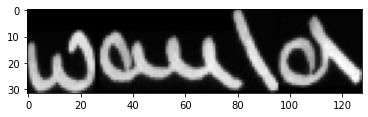



original_text =   appear
predicted text = appear

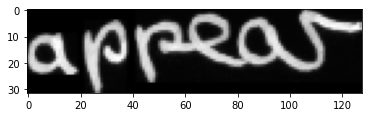



original_text =   to
predicted text = to

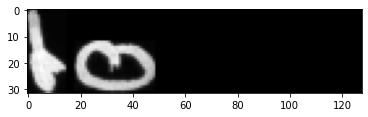



original_text =   "
predicted text = "

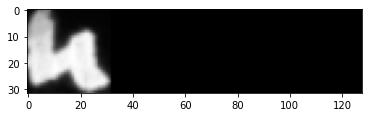



original_text =   up
predicted text = up

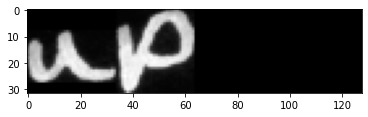



original_text =   "
predicted text = "

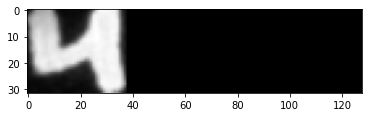



original_text =   an
predicted text = an

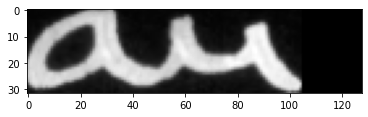



original_text =   out-
predicted text = out-

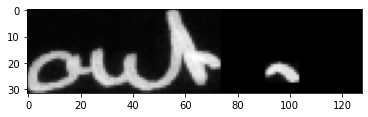



original_text =   large
predicted text = layge

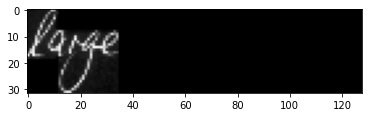



original_text =   majority
predicted text = mjoily

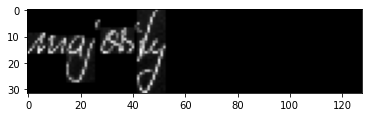

In [46]:
# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_texts[200+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[200+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')
     

In [48]:
# Defining arguments for plotting graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

In [49]:
 # Function for plotting training & validation accuracy values
def plotgraph(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

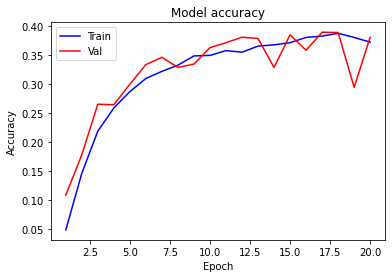

In [51]:
# Accuracy vs epochs graph

plotgraph(epochs, acc, val_acc)

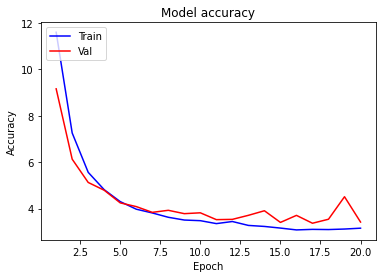

In [50]:
# Loss vs epochs graph

plotgraph(epochs, loss, val_loss)